<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/tutorials/P3.1_rnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P3.3 - Sequence to Sequence: Text Translation

In this practical we will develop a model for translation of sentences from German to English using the sequence to sequence architecture. 

### Learning outcomes
- Understand the basic concepts of a sequence to sequence (seq2seq) model
- How to preprocess textual data.
- How to train an seq2seq model for parametrisation of the joint probability distribution $P(y_0, ..., y_k | x_0, ..., x_n)$ over the words $Y$ in the target language, conditioned on the words $X$ of the source sentence.
- How to develop a model for translation of sentences from $P(y_0, ..., y_k | x_0, ..., x_n)$.

**References**
* [1] *Ilya Sutskever, Oriol Vinyals, Quoc V. Le, "Sequence to Sequence Learning with Neural Networks"*, NIPS, 2014. https://arxiv.org/abs/1409.3215

### Download data

We train a translation model on the multi30K dataset. The dataset was specifically designed for machine translation and evaluation tasks and contains short translations from/to English to/from German.

We will be downloading the dataset via the `torchnlp` library (command to install via pip is next to import). The dataset is then processed in a similar way as in P3.1_rnn_classification.

In [14]:
from torchnlp.datasets import multi30k_dataset #pip install pytorch-nlp

train_data, test_data = multi30k_dataset(train=True, test=True)


print(f"Number of training sentences: {len(train_data)}")
print(f"Number of test sentences: {len(test_data)}\n\n")


test_iterator = iter(test_data)
for _ in range(3):
    batch = next(test_iterator)
    print("DE: " + batch['de'])
    print("EN: " + batch['en'] + '\n')


Number of training sentences: 29000
Number of test sentences: 1000


DE: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
EN: A man in an orange hat starring at something.

DE: Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.
EN: A Boston Terrier is running on lush green grass in front of a white fence.

DE: Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt.
EN: A girl in karate uniform breaking a stick with a front kick.



# Preprocessing textual input data

### Create vocabulary
As we have seen in practical P1.2 and P3.2, word embeddings are useful for encoding words into vectors of real numbers. The first step is to build a custom vocabulary from the raw training dataset. To this end, we tokenize each sentence and thereafter count the number of occurances of each token (=word or punctuation mark) in each of the articles using `counter`. Finally, we create the vocabulary by using the frequencies of each token in the counter. 

Note that each datapoint consists of a German and English sentence, thus we create seperate tokenizers and vocabulary for both languages. Futhermore, we add special tokens to both vocabulary: $<unk>$ for unknown tokens, $<pad>$ for padding, $<start>$ and $<end>$ as the first and last tokens of each sentence, respectively.

In [ ]:
!python -m spacy download de
!python -m spacy download en

In [15]:
import torch
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import spacy
from tqdm.notebook import tqdm

de_counter, en_counter = Counter(), Counter()

de_tokenizer = de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = en_tokenizer = get_tokenizer('spacy', language='en')

for batch in tqdm(train_data):
    
    en, de = batch.values()
    
    de_counter.update(de_tokenizer(de))
    en_counter.update(en_tokenizer(en))
    
    
de_vocab = Vocab(de_counter, min_freq=2, specials=['<unk>', '<start>', '<stop>', '<pad>'])
en_vocab = Vocab(en_counter, min_freq=2, specials=['<unk>', '<start>', '<stop>', '<pad>'])

print(f"Unique tokens in source (de) vocabulary: {len(de_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(en_vocab)}")

Unique tokens in source (de) vocabulary: 8015
Unique tokens in target (en) vocabulary: 6191


### Create pipelines 

In the paper we are implementing, they find it beneficial to reverse the order of the input which they believe "introduces many short term dependencies in the data that make the optimization problem much easier". We adopt this approach and reverse the German sentence after it has been transformed into a list of tokens.

**Exercise**

Complete the pipeline functions that preprocess German and English sentences respectively. The German sentences should be reversed first. Then, for both German and English sentences your code should add start and stop tokens to each sentence at appropriate positions. 

In [1]:
def de_pipeline(text):
    """
    Reverses German sentence and tokizes from a string into a list of strings (tokens). Then converts each token
    to corresponding indices. Furthermore, it adds a start token at the appropriate position.
    """
    ### Your code here ###
    
    return word_idcs

def en_pipeline(text):
    """
    Tokenizes English sentence from a string into a list of strings (tokens), then converts each token
    to corresponding indices. Furthermore, it adds a start token at the appropriate position
    """
    ### Your code here ###
    
    return word_idcs



The pipelines allow us to convert a string sentence into integers:

    en_pipeline('Here is an example!')
    >>> [1, 1034, 10, 28, 0, 1208, 2]

### Create DataLoaders

**Exercise**

Use the pipelines from the previous exercise to create a `collate_batch` method produces batches of source and target sentences. As you may have foreseen, the `collate_batch` will be used in the `DataLoader` which enables iterating over the dataset in batches. In each iteration, a batch of source sentences (German) and target sentences (English) should be returned. Encode the tokens of the sentences as indices by using the vocabulary. Finally, your code should pad all sequences to be able to create two tensors: one containing the input sentences, and another one for the target sentences. Pad the sequences with the appropriate special token.

In [19]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    ### Your code here ###
    
    # return source (DE) and target sequences (EN) after transferring them to GPU (if available)
    return de_padded.to(device).T, en_padded.to(device).T



# Building the Seq2Seq translation model

In the implementation we define three objects: the encoder, the decoder and a full translation model that encapsulates the encoder and decoder. The given code also proposes the main hyperparameters that your implementation should use. Feel free to change the values of these parameters!

The referenced paper uses a 4-layer LSTM, but in the interest of training time we can reduce this to 2-layers. The concept of multi-layer RNNs is easy to expand from 2 to 4 layers.

## Encoder

The encoder takes as input a (batch) German sentence. We already converted all sentences into a zero-padded 2D matrix (shape batch_size, max_seq_len)) containing the tokens that make up the sequences. 

**Exercise**:
Complete the Encoder's class. In the `__init__(self)` you should declare the approriate layers. The encoder has to return a compact representation of the input sequence.

In [20]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, source_vocab, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        
        self.source_vocab = source_vocab
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        ### Your code here ###
        
        
    def forward(self, src):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector 
        
        Input:
        src shape:  [max_seq_len_in_batch, batch_size]

        Output:
        hidden and cell dense vectors (hidden and cell)
        which contains all sentence information, shape [n layers, batch size, hid dim]
        """
        
        ### Your code here ###
        
        return hidden, cell

### Decoder

**Exercise**

The next step is to implement the decoder. The Decoder class aims at performing a single step of decoding, i.e. it ouputs a single token per time-step. In the first decoding step ($t=1$), the decoder takes as input the dense representation first token $y_2 = f$(<<l>start>). With these inputs, it should update the cell and hidden state and thereafter predict the first real word $s_2$ (no start token) of the target sentence. In all later decoder steps, the first layer will receive a hidden and cell state from the previous time-step, $(h_{t-1}, c_{t-1})$, and feed it through the LSTM with the current embedded token, $y_t$ (i.e the embedding that of the token predicted at the end of the previous step), to produce a new hidden and cell state, $(h_t, c_t)$. 

You should then pass the hidden state of the RNN, $h_t$, through a linear layer, $g$, to make a prediction of what the next token in the target (output) sequence should be, i.e. $\hat{y}_{t+1} = g(h_t)$. An example is provided in the diagram below.

![alt text](lstm_decoder.png "diagram")

In [5]:
class Decoder(nn.Module):
    def __init__(self, target_vocab, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.target_vocab = target_vocab
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        ### Your code here ###
    
        
    def forward(self, input, hidden, cell):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sentence in
        the target language
        
        Input:
        hidden shape: [n layers, max_seq_len, hid dim]
        cell shape: [n layers, batch size, hid dim]
        input shape: [batch size]
        
        Output:
        prediction shape: [batch size, num_words_target_vocabulary]
        hidden shape: [n layers, batch size, hid dim]
        cell shape: [n layers, batch size, hid dim]
        """
        
        ### Your code here ###
        
        return prediction, hidden, cell

## The seq2seq model

**Exercise**

The Seq2Seq model takes in an Encoder, Decoder, and a device (used to place tensors on the GPU, if it exists).
For this implementation, we you have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the Encoder and Decoder. 

Start with declaring the optimizer and loss function of the model. The loss function should not penalize if the ground truth token is the <<l>pad> token. Use the `ignore_index` input argument of the loss function to realize this behavior.


The forward method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step the decoder will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability 1 - `teacher_forcing_ratio`, your model should use the token that the LSTM predicted at the end of the previous step, even if it doesn't match the actual next token in the sequence. The `random.random()` will be useful here, the module has already been imported.

    

In [26]:
import torch.optim as optim
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        ### Your code here ###
        

        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.
        
        Inputs:
        src: padded index representation of source sentences with shape [src len, batch size]
        trg:  padded index representation of target sentences with shape [trg len, batch size]
        teacher_forcing_ratio: probability to use teacher forcing, e.g. 0.5 we use ground-truth target sentence 50% of the time
        
        Outputs:
        outputs: padded index representation of the predicted sentences with shape [trg_len, batch_size, trg_vocab_size]
        """
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = len(self.decoder.target_vocab)
        
        ### Your code here ###
        
        return outputs

## Training

**Exercise** 

Write functions for training and evaluating your model. You should iterate over the dataset and update the weights of the networks with the computed loss value. Print the value of training and validation loss at the end of each epoch. 

Next, you will need to call your `seq2seq` model and train it using the functions that you implemented. Finally, make a plot of the training and validation accuracy.

As the model needs extensive training, it could be useful to save the best model to your (local) drive. In this way, you can do the next exercise at another time. Use the following code inside your training loop:
    
    if val_loss < best_valid_loss:
        best_val_loss = val_loss
        torch.save(seq2seq.state_dict(), 'p3.3-model.pt')
        
Don't forget to declare `best_valid_loss` at the top of the cell, e.g. with 

    best_valid_loss = float('inf')
    
Finally, the GPU memory will gradually increase which eventually triggers a memory error. Make sure to clear the GPU memory before running the forward pass using the `torch.cuda.empty_cache()` command.

**Solution**

The training and evaluation functions of P3.1 and P3.2 can be used with some  modifications: via tensor slicing we neglect the first token of each sequence in the calculations of the loss and accuracy. Furthermore, we removed the accuracy metrics.




In [11]:
BATCH_SIZE = 128
N_EPOCHS = 15
CLIP = 1
DROPOUT = 0.5
N_LAYERS = 2 #paper uses 4

EMB_DIM = 256  #dimension of the word embedding
HIDDEN_DIM = 512 #dimension of the lstm's hidden state

In [12]:
from tqdm.notebook import tqdm

def train(dataset, clip=CLIP):
    
    ### Your code here ###
        
    return epoch_loss / len(dataloader)


def evaluate(dataset):
    
    ### Your code here ###
    
    seq2seq.eval()
    
    return epoch_loss / len(dataloader)

In [8]:
# initiate seq2seq translation model

### Your code here ###

In [7]:
import time

best_valid_loss = float('inf')


train_loss_arr = []; val_loss_arr = []
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()
    
    ### Your code here ###
    
    
    
    train_loss_arr.append(train_loss); val_loss_arr.append(val_loss)
    
    if val_loss < best_valid_loss:
        best_val_loss = val_loss
        torch.save(seq2seq.state_dict(), 'tut1-model.pt')
    
    print('-' * 76)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'valid loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time, 
                                           train_loss_arr[-1],
                                           val_loss_arr[-1]))
    print('-' * 76)

Populating the interactive namespace from numpy and matplotlib


/data/storage8/jwillems/anaconda3/envs/torch/lib/python3.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['CLIP', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


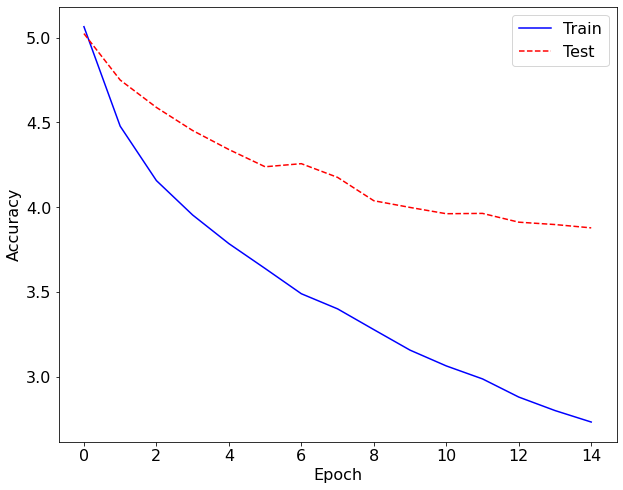

In [16]:
### Make a plot with training/testing accuracy vs. epochs ###
%pylab inline


# Inference

The trained model parametrizes the joint probability distribution $P(Y|X)$ of an English target sentence $Y$ that is a correct translation of the German source sentence $X$. Formally, we seek the sentence $Y$ which maximizes $P(Y|X)$, i.e. 

$$
Y = \underset{Y^{'}}{\operatorname{argmax}} p(Y^{′}|X). \quad{(1)}
$$

**Exercise** 

During inference using the seq2seq model you can make certain assumptions that should affect your implementation choices. You can assume conditional indepedance of the targets $P(Y|X)=P(y_{0:k}|X)=P(y_0|X)P(y_1|X)...P(y_k|X)$. In this case you can implement a greedy decoder that computes the most likely output at each step without taking into acount the selected outputs at previous steps. Or you can implement an autoregressive decoder that computes the joint probability of the output given the input $P(Y|X)=P(y_{0:k}|X)=P(y_0|X)P(y_1|y_0, X)...P(y_k|y_{0:k-1},X)$. 


In [6]:
### Your code here ###